In [2]:
import numpy as np
import cv2
from show_image import *
from datascience import *
import math
%matplotlib inline

---

- ## 에지(edge) 검출
    - ### 에지: 화소값이 급격하게 변하는 부분
    - ### 객체에서 크기, 위치, 모양, 방향성 탐지를 위해 경계선 검출

---

- ## 1차 미분 마스크
    - #### 밝기에 대한 기울기를 계산
    - #### 영상은 연속된 데이터가 아닌 이산된 데이터로 이루어져 있으므로 근사하여 계산

![image](https://github.com/kks00/visual_info_processing/assets/68108664/1a084620-cf35-4b8f-93a7-1ff2b5d4f025)
![image](https://github.com/kks00/visual_info_processing/assets/68108664/066d6a5b-f51f-4f0d-a058-90b45c843f7b)


- #### 다음과 같이 마스크를 구성하여 회선 수행 시 미분 결과와 같은 결과가 됨
    - ### $G(x) = f(x+1,y) - f(x,y)$
    - ### $G(y) = f(x,y+1) - f(x,y)$

<br>

- #### 마스크 계수의 합은 0이 되어야 함

<br><br>

- ## 로버츠 마스크
    - #### 대각선 방향으로 1과 -1 배치
    - #### 차분의 크기가 작기 때문에 경계가 확실한 에지만을 검출
    - #### 잡음에 민감
    - #### Edge의 강도가 약함
 
<br>
 
![image](https://github.com/kks00/visual_info_processing/assets/68108664/144d0e62-b00b-49d1-8307-4507ca8a46a2)

- ### Roberts Edge $ = \sqrt{Gx^2 + Gy^2}$

<br>

In [20]:
def convolution(source, mask):
    mask_n = mask.shape[0]
    source_h, source_w = source.shape
    
    result = np.zeros(source.shape, dtype="float32") # 출력 이미지 생성

    mask_center = mask_n // 2
    center_y, center_x = source_h // 2, source_w // 2
    for center_y in range(mask_center, source_h - mask_center): # 현재 mask가 위치한 지점의 mask 중심점
        for center_x in range(mask_center, source_w - mask_center):
            roi = source[center_y-mask_center:center_y+mask_center+1, center_x-mask_center:center_x+mask_center+1] # 입력 영상에서 마스크가 위치한 지점 추출
            result.itemset((center_y, center_x), np.sum(np.multiply(roi, mask))) # mask와 곱한 값의 합을 결과 영상에 대입

    return result

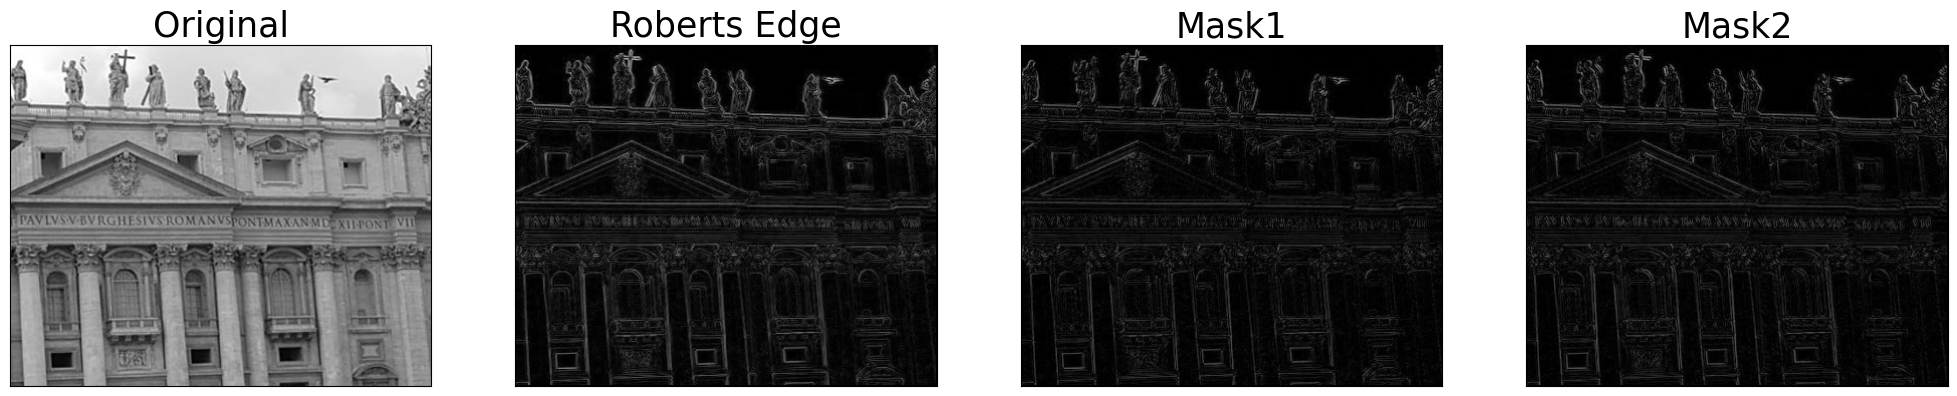

In [21]:
image = cv2.imread("./images/chap07/edge.jpg", cv2.IMREAD_GRAYSCALE)
mask1 = [[-1, 0, 0],
         [0, 1, 0],
         [0, 0, 0]]
mask2 = [[0, 0, -1],
         [0, 1, 0],
         [0, 0, 0]]

mask1_conv = convolution(image, np.array(mask1, dtype="float32"))
mask2_conv = convolution(image, np.array(mask2, dtype="float32"))
mask1_conv, mask2_conv = np.abs(mask1_conv), np.abs(mask2_conv) # 회선 결과 행렬 양수로 변경

roberts_edge = cv2.magnitude(mask1_conv, mask2_conv).astype("uint8") # Roberts Edge 구하기

mask1_conv, mask2_conv = np.clip(mask1_conv, 0, 255).astype('uint8'), np.clip(mask2_conv, 0, 255).astype('uint8') # 형변환 및 클램핑

show_images({"Original": image, "Roberts Edge": roberts_edge, "Mask1": mask1_conv, "Mask2": mask2_conv}, 25)

<br><br>

- ## 프리윗 마스크
    - #### 수직, 수평방향 원소 배치
    - #### 세번의 차분을 합하기 때문에 Roberts Edge보다 강도 강함
    - #### 수직, 수평에지 찾는데 유리
 
<br>
 
![image](https://github.com/kks00/visual_info_processing/assets/68108664/c1e9edbe-bb1c-4334-8b0a-8ccd0f4e9c8d)
- ### Prewitt Edge $ = \sqrt{Gx^2 + Gy^2}$

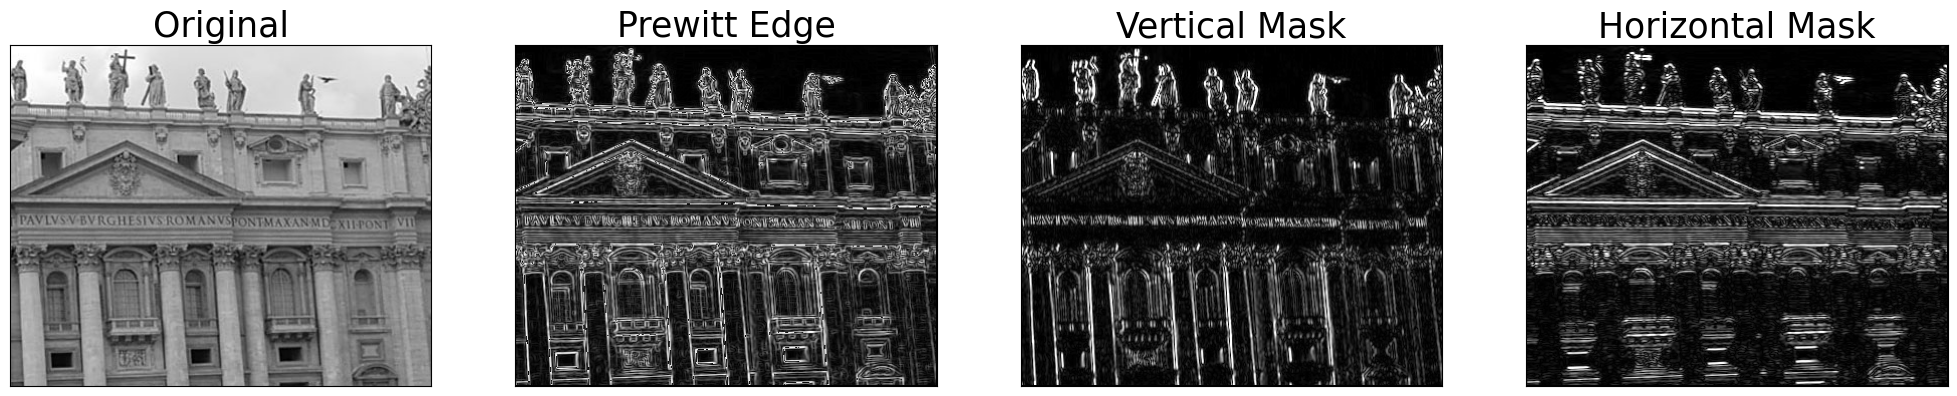

In [23]:
image = cv2.imread("./images/chap07/edge.jpg", cv2.IMREAD_GRAYSCALE)
vert_mask = [[-1, 0, 1],
         [-1, 0, 1],
         [-1, 0, 1]]
horz_mask = [[-1, -1, -1],
         [0, 0, 0],
         [1, 1, 1]]

vert_conv = convolution(image, np.array(vert_mask, dtype="float32"))
horz_conv = convolution(image, np.array(horz_mask, dtype="float32"))
vert_conv, horz_conv = np.abs(vert_conv), np.abs(horz_conv) # 회선 결과 행렬 양수로 변경

prewitt_edge = cv2.magnitude(vert_conv, horz_conv).astype("uint8") # Roberts Edge 구하기

vert_conv, horz_conv = np.clip(vert_conv, 0, 255).astype('uint8'), np.clip(horz_conv, 0, 255).astype('uint8') # 형변환 및 클램핑

show_images({"Original": image, "Prewitt Edge": prewitt_edge, "Vertical Mask": vert_conv, "Horizontal Mask": horz_conv}, 25)

<br><br>

- ## 소벨 마스크
    - #### 프리윗 마스크에서 중심계수에 대한 차분 비중을 2배로 키움
        - #### 대각선 방향 에지 검출 강화
    - #### cv2.Sobel() 메소드 존재
     
<br>

![image](https://github.com/kks00/visual_info_processing/assets/68108664/f4dd62e5-37f3-4532-be28-619b02d29ca2)
- ### Sobel Edge $ = \sqrt{Gx^2 + Gy^2}$

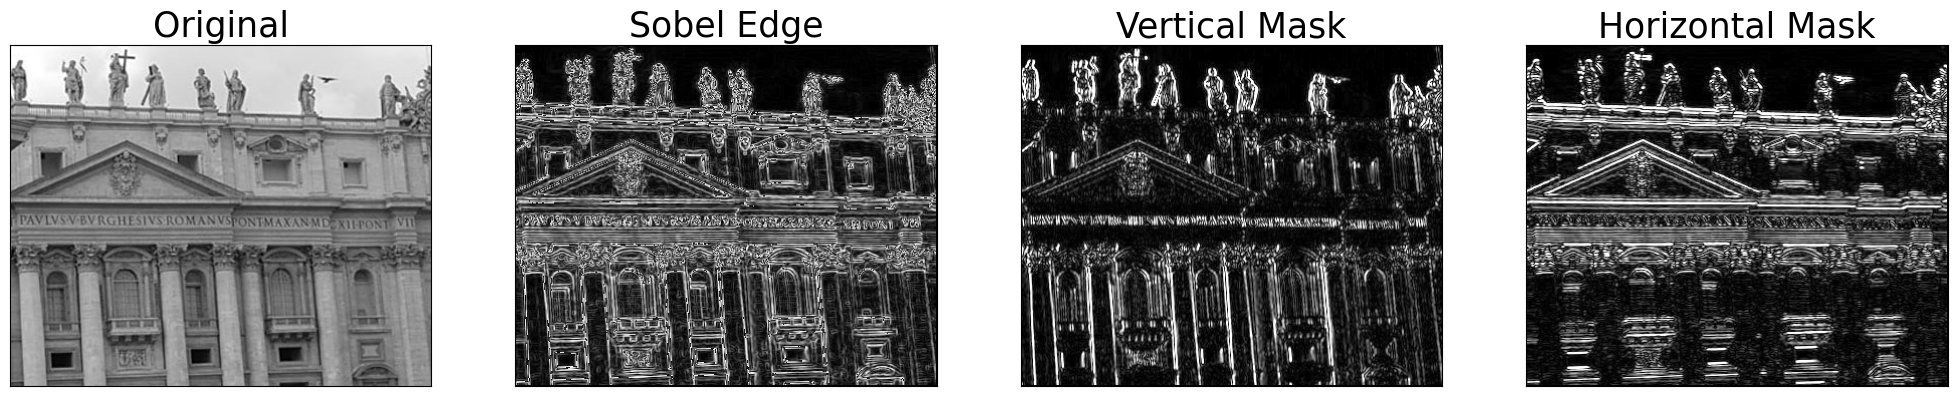

In [24]:
image = cv2.imread("./images/chap07/edge.jpg", cv2.IMREAD_GRAYSCALE)
vert_mask = [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]]
horz_mask = [[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]]

vert_conv = convolution(image, np.array(vert_mask, dtype="float32"))
horz_conv = convolution(image, np.array(horz_mask, dtype="float32"))
vert_conv, horz_conv = np.abs(vert_conv), np.abs(horz_conv) # 회선 결과 행렬 양수로 변경

sobel_edge = cv2.magnitude(vert_conv, horz_conv).astype("uint8") # Roberts Edge 구하기

vert_conv, horz_conv = np.clip(vert_conv, 0, 255).astype('uint8'), np.clip(horz_conv, 0, 255).astype('uint8') # 형변환 및 클램핑

show_images({"Original": image, "Sobel Edge": sobel_edge, "Vertical Mask": vert_conv, "Horizontal Mask": horz_conv}, 25)

---

- ## 2차 미분 마스크
    - #### 1차 미분은 점진적으로 밝기가 변화하는 부분도 에지로 검출
    - #### 변화 영역 중심에 위치하는 에지만 검출

<br><br>

- ## 라플라시안 에지 검출
    - #### cv2.Laplacian 메소드 존재
    - #### 잡음 성분에 매우 민감
![image](https://github.com/kks00/visual_info_processing/assets/68108664/7a8fd884-786c-4dde-9159-20661f0afa9b)

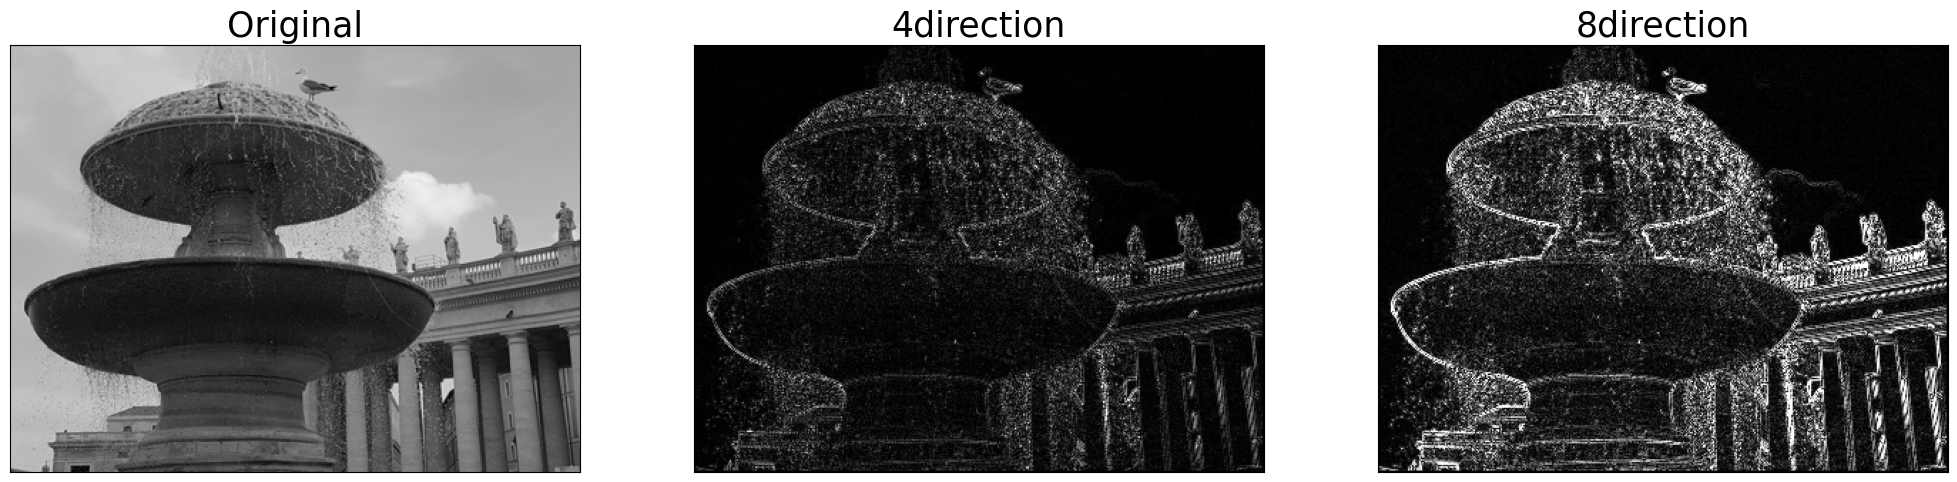

In [27]:
image = cv2.imread("./images/chap07/laplacian.jpg", cv2.IMREAD_GRAYSCALE)
mask4 = [[0, 1, 0],
         [1, -4, 1],
         [0, 1, 0]]
mask8 = [[-1, -1, -1],
         [-1, 8, -1],
         [-1, -1, -1]]

mask4_conv = convolution(image, np.array(mask4, dtype="float32"))
mask8_conv = convolution(image, np.array(mask8, dtype="float32"))

mask4_conv, mask8_conv = np.abs(mask4_conv), np.abs(mask8_conv) # 회선 결과 행렬 양수로 변경
mask4_conv, mask8_conv = np.clip(mask4_conv, 0, 255).astype('uint8'), np.clip(mask8_conv, 0, 255).astype('uint8') # 형변환 및 클램핑

show_images({"Original": image, "4direction": mask4_conv, "8direction": mask8_conv}, 25)

<br><br>

- ## LoG (Laplacian of Gaussian)
    - ### 라플라시안이 잡음에 민감하므로, 잡음을 먼저 제거하고 라플라시안을 수행
    - ### 잡음 제거: 가우시안 블러
        - #### 중심에서 멀어질수록 가중치 낮아지는 형태
        - #### 복잡한 공식에 의해 블러 마스크를 생성하여야 함

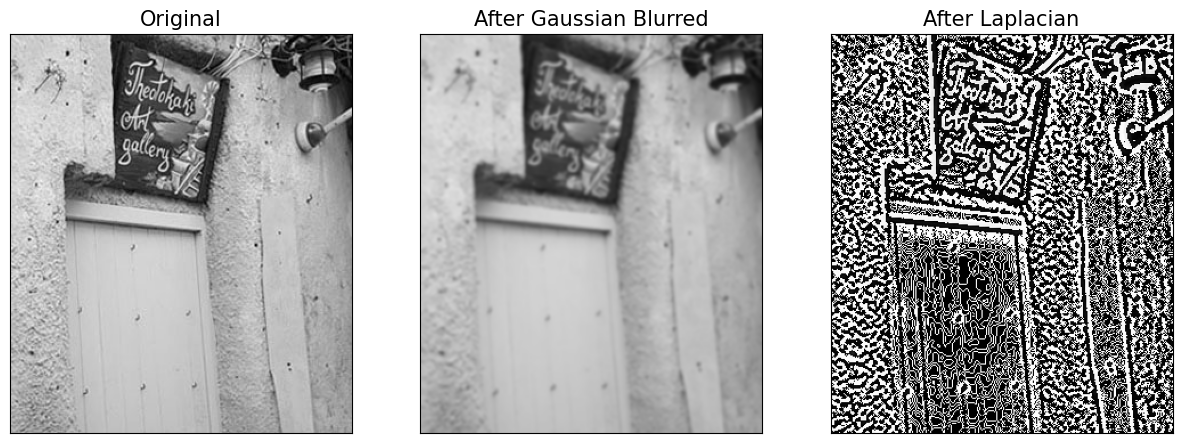

In [34]:
image = cv2.imread("./images/chap07/dog.jpg", cv2.IMREAD_GRAYSCALE)

gaus = cv2.GaussianBlur(image, (7, 7), 0, 0) # 가우시안 블러 수행

log = cv2.Laplacian(gaus, cv2.CV_16S, 7).astype("uint8") # 라플라시안 수행

show_images({"Original": image, "After Gaussian Blurred": gaus, "After Laplacian": log}, 15)

<br><br>

- ## DoG (Difference of Gaussian)
    - ### 가우시안 스무딩 필터링의 차를 이용하여 에지를 검출
    - ### 표준편차가 작은 가우시안 분포 - 표준편차가 큰 가우시안 분포

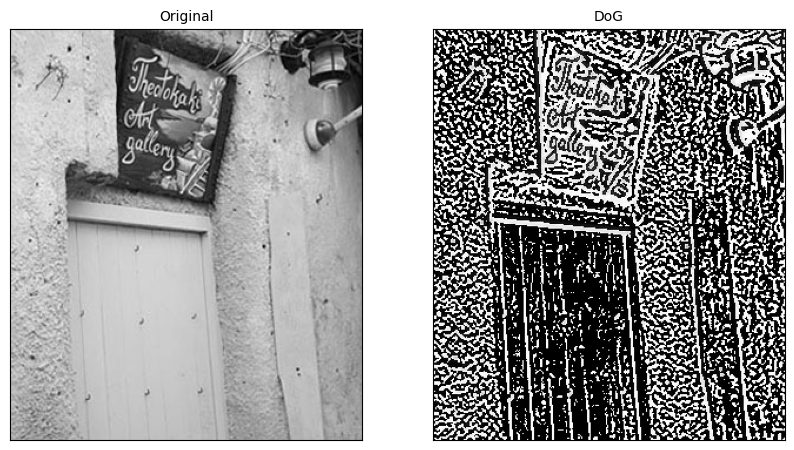

In [40]:
image = cv2.imread("./images/chap07/dog.jpg", cv2.IMREAD_GRAYSCALE)

blur1 = cv2.GaussianBlur(image, (3, 3), 0) # 가우시안 블러 수행
blur2 = cv2.GaussianBlur(image, (9, 9), 0) # 가우시안 블러 수행
dog = np.uint8(blur1 - blur2)

show_images({"Original": image, "DoG": dog}, 10)

<br><br>

- ## 캐니 에지 검출

- ### 1. 가우시안 블러링을 통한 노이즈 제거

- ### 2. 화소 기울기의 강도와 방향 검출
    - #### 1. 가로방향, 세로방향의 소벨 마스크 회선 적용
    - #### 2. 기울기 (0, 45, 90, 135) 로 근사화

- ### 3. 비최대치 억제: 에지를 얇게 만들기 위함
    - #### Sobel Edge 영상을 사용
    - #### 1. 기울기 방향과 수직인 에지의 방향에 있는 이웃 화소 선택
    - #### 2. 이웃 화소들보다 현재 화소가 큰 것들만 에지로 보존
 
![image](https://github.com/kks00/visual_info_processing/assets/68108664/722ed86b-488b-46b5-be96-c9e8ff76d031)

![image](https://github.com/kks00/visual_info_processing/assets/68108664/354a0e19-ef11-42c5-8d84-b15eb7442191)

- ### 4. 이력 임계 처리
    - #### 모든 Edge의 강도가 낮은 임계값보다 높고, 높은 임계값을 넘는 Edge가 1개라도 존재하는 Edge만 선택
        - #### Edge의 강도가 높은 임계값보다 큰 지점부터 8방향 DFS 탐색
        - #### 낮은 임계값보다 현재 Edge의 강도가 높을 경우에만 주변 탐색

<br>

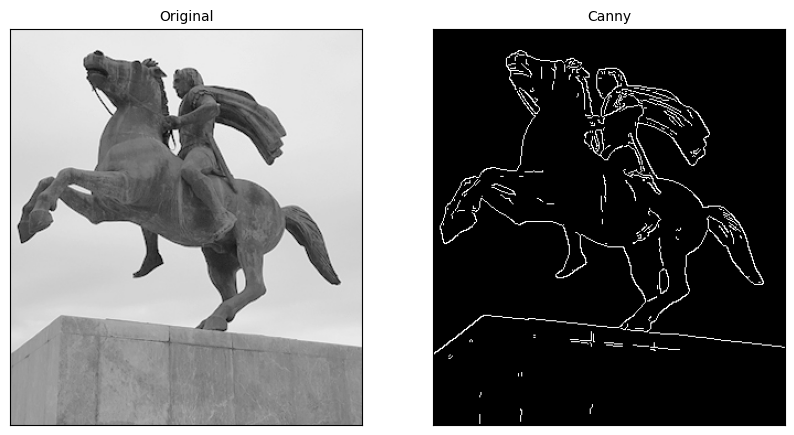

In [48]:
def nonmax_suppression(sobel, direct):
    rows, cols = sobel.shape[:2]
    dst = np.zeros((rows, cols), np.float32)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # 행렬 처리를 통해 이웃 화소 가져오기
            values = sobel[i-1:i+2, j-1:j+2].flatten()
            first = [3, 0, 1, 2]
            id = first[direct[i, j]]
            v1, v2 = values[id], values[8-id]

            dst[i, j] = sobel[i, j] if (v1 < sobel[i , j] > v2) else 0
    return dst

def trace(max_sobel, i, j, low):
    h, w = max_sobel.shape
    if (0 <= i < h and 0 <= j < w) == False: return  # 추적 화소 범위 확인
    if pos_ck[i, j] == 0 and max_sobel[i, j] > low:
        pos_ck[i, j] = 255
        canny[i, j] = 255

        trace(max_sobel, i - 1, j - 1, low)# 추적 함수 재귀 호출 - 8방향 추적
        trace(max_sobel, i    , j - 1, low)
        trace(max_sobel, i + 1, j - 1, low)
        trace(max_sobel, i - 1, j    , low)
        trace(max_sobel, i + 1, j    , low)
        trace(max_sobel, i - 1, j + 1, low)
        trace(max_sobel, i    , j + 1, low)
        trace(max_sobel, i + 1, j + 1, low)

def hysteresis_th(max_sobel, low, high):                # 이력 임계값 수행
    rows, cols = max_sobel.shape[:2]
    for i in range(1, rows - 1):  # 에지 영상 순회
        for j in range(1, cols - 1):
            if max_sobel[i, j] > high:  trace(max_sobel, i, j, low)  # 추적 시작

image = cv2.imread("images/chap07/canny.jpg", cv2.IMREAD_GRAYSCALE)

pos_ck = np.zeros(image.shape[:2], np.uint8)
canny = np.zeros(image.shape[:2], np.uint8)

gaus_img = cv2.GaussianBlur(image, (5, 5), 0.3)
Gx = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 1, 0, 3)  # x방향 마스크
Gy = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 0, 1, 3)  # y방향 마스크
sobel = cv2.magnitude(Gx, Gy)                            # 두 행렬 벡터 크기
directs = cv2.phase(Gx, Gy) / (np.pi / 4)
directs = directs.astype(int) % 4
max_sobel = nonmax_suppression(sobel, directs)   # 비최대치 억제
hysteresis_th(max_sobel, 100, 150)          # 이력 임계값

show_images({"Original": image, "Canny": canny}, 10)